In [1]:
# === Cell 1 (PATCHED v2): imports & config, disable inductor; no TORCH_LOGS ===
import os
os.environ["TORCHINDUCTOR_DISABLE"] = "1"
os.environ.pop("TORCH_LOGS", None)
import math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim import Adam
from torch import amp

# Repro & device
torch.manual_seed(0); np.random.seed(0); random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

# AMP on CUDA only
use_amp = (device.type == 'cuda')

# Hyper-params
lambda_w = 0.1
critic_lr = 1e-3
theta_lr  = 1e-2
critic_steps_per_theta = 5
M = 2048             # MC samples per critic step
inner_steps = 20     # c-transform GD steps
inner_step_size = 0.10


In [2]:
from scipy.stats import beta

# --- Parameters ---
N = 300
n_noise = 7 # Number of noise samples per corner
n_signal = N - 2 * n_noise
p = 1
np.random.seed(42)

# --- Signal from Beta(p,p) × Beta(p,p) ---
signal = np.column_stack((
    beta.rvs(p, p, size=n_signal),
    beta.rvs(p, p, size=n_signal)
))

# --- Noise cluster 1 (near (0,0))
noise1 = np.column_stack((
    beta.rvs(1, 50, size=n_noise),
    beta.rvs(1, 50, size=n_noise)
))

# --- Noise cluster 2 (near (1,1))
noise2 = np.column_stack((
    beta.rvs(50, 1, size=n_noise),
    beta.rvs(50, 1, size=n_noise)
))

# --- Combine ---
X_np = np.vstack([signal, noise1, noise2])

# --- Torch tensor on device ---
X = torch.tensor(X_np, dtype=torch.get_default_dtype(), device=device)  # (N,2)
n = X.shape[0]

print(X.shape) #tester; should be (300, 2)

torch.Size([300, 2])


C:\Users\12822\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5070 Ti Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


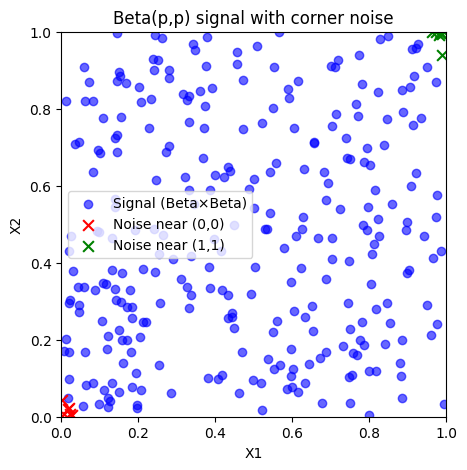

In [3]:
import matplotlib.pyplot as plt

n_signal = signal.shape[0]
n_noise = noise1.shape[0] + noise2.shape[0]
plt.figure(figsize=(5,5))
plt.scatter(signal[:,0], signal[:,1], 
            c="blue", alpha=0.6, label="Signal (Beta×Beta)")
plt.scatter(noise1[:,0], noise1[:,1], 
            c="red", marker="x", s=60, label="Noise near (0,0)")
plt.scatter(noise2[:,0], noise2[:,1], 
            c="green", marker="x", s=60, label="Noise near (1,1)")

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Beta(p,p) signal with corner noise")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.gca().set_aspect("equal", "box")
plt.show()

In [4]:
# class ThetaGaussian(nn.Module):
#     def __init__(self, mu_init=(0.,0.), log_diag_cov_init=(-0.3,-0.3)):
#         super().__init__()
#         self.mu = nn.Parameter(torch.tensor(mu_init, dtype=torch.get_default_dtype(), device=device))
#         self.log_diag_cov = nn.Parameter(torch.tensor(log_diag_cov_init, dtype=torch.get_default_dtype(), device=device))

#     @torch.no_grad()
#     def _std(self):
#         return torch.exp(0.5*self.log_diag_cov)

#     def sample(self, M):
#         eps = torch.randn(M, 2, device=device, dtype=torch.get_default_dtype())
#         return self.mu[None, :] + eps * self._std()[None, :]

#     def log_prob(self, z):
#         var = torch.exp(self.log_diag_cov)
#         return -0.5*((z-self.mu)**2/var).sum(-1) - 0.5*torch.log(2*torch.pi*var).sum()

# theta = ThetaGaussian().to(device)
# theta_opt = Adam(theta.parameters(), lr=theta_lr)


In [5]:
def sample_F(M):
    # Samples from F = Uniform([0,1]^2)
    return torch.rand(M, 2, device=device, dtype=torch.get_default_dtype())


In [6]:
# === Cell 4 (PATCHED): ICNN critic without torch.compile ===
class ICNNCritic(nn.Module):
    def __init__(self, in_dim=2, hidden=128):
        super().__init__()
        self.z1 = nn.Linear(in_dim, hidden, bias=True)
        self.W1 = nn.Linear(in_dim, hidden, bias=False)  # constrained >= 0
        self.z2 = nn.Linear(hidden, hidden, bias=True)
        self.W2 = nn.Linear(in_dim, hidden, bias=False)  # constrained >= 0
        self.out = nn.Linear(hidden, 1, bias=True)
        with torch.no_grad():
            self.W1.weight.data.abs_()
            self.W2.weight.data.abs_()

    def forward(self, x):
        # enforce convexity by clamping hidden-to-input weights
        self.W1.weight.data.clamp_(min=0)
        self.W2.weight.data.clamp_(min=0)
        h = F.relu(self.z1(x) + self.W1(x))
        h = F.relu(self.z2(h) + self.W2(x))
        return self.out(h).squeeze(-1)

phi = ICNNCritic().to(device)
phi_opt = Adam(phi.parameters(), lr=critic_lr)


In [7]:
# === Cell 5 (PATCHED): c-transform using torch.amp.autocast ===
def c_transform(phi, z, steps=20, step_size=0.10):
    """
    ϕ^c(z) = min_x [ 0.5||x - z||^2 - ϕ(x) ]
    Inner GD runs without tracking grads for x-updates; we return
    a clean forward pass with grads for outer variables (ψ, θ).
    """
    # Initialize x at z
    x = z.detach().clone()

    for _ in range(steps):
        x.requires_grad_(True)
        with amp.autocast(device_type='cuda', enabled=use_amp):
            val = 0.5*((x - z)**2).sum(-1) - phi(x)  # (m,)
            loss = val.mean()
        g = torch.autograd.grad(loss, x, create_graph=False)[0]
        with torch.no_grad():
            x = x - step_size * g

    x = x.detach().requires_grad_(True)
    with amp.autocast(device_type='cuda', enabled=use_amp):
        result = 0.5*((x - z)**2).sum(-1) - phi(x)    # (m,)
    return result


In [8]:
# # === Cell 6 (PATCHED): critic objective J(θ, ψ) with new AMP API ===
# def critic_objective(phi, theta, X, M, lambda_w):
#     Z = theta.sample(M)  # (M,2)
#     with amp.autocast(device_type='cuda', enabled=use_amp):
#         phi_X = phi(X)                      # (n,)
#         ct_Z  = c_transform(phi, Z, steps=inner_steps, step_size=inner_step_size)  # (M,)
#         term_model = (2*lambda_w) * ct_Z.mean()
#         term_data  = torch.log(torch.tensor(X.shape[0], device=device, dtype=torch.get_default_dtype())) \
#                    - torch.logsumexp(-2*lambda_w * phi_X, dim=0)
#         J = term_model + term_data
#     return J


In [9]:
def critic_objective(phi, X, M, lambda_w):
    Z = sample_F(M)  # (M,2) from F = Uniform([0,1]^2)
    with amp.autocast(device_type='cuda', enabled=use_amp):
        phi_X = phi(X)                      # (n,)
        ct_Z  = c_transform(phi, Z, steps=inner_steps, step_size=inner_step_size)  # (M,)
        term_model = (2*lambda_w) * ct_Z.mean()
        term_data  = torch.log(torch.tensor(X.shape[0], device=device, dtype=torch.get_default_dtype())) \
                   - torch.logsumexp(-2*lambda_w * phi_X, dim=0)
        J = term_model + term_data
    return J

In [10]:
@torch.no_grad()
def compute_weights(phi, X, lambda_w):
    phi_X = phi(X)
    phi_X = phi_X - phi_X.mean() # center potentials
    s = -2*lambda_w * phi_X
    s = torch.clamp(s, -50, 50) # prevent overflow/underflow
    w = torch.softmax(s, dim=0)
    return w


In [11]:
# === Cell 8 (PATCHED v2): training loop with compatible GradScaler ===
from torch import amp
scaler = amp.GradScaler(enabled=use_amp)   # ← removed device_type kwarg

# def critic_ascent_step():
#     phi_opt.zero_grad(set_to_none=True)
#     J = critic_objective(phi, theta, X, M, lambda_w)
#     loss_phi = -J
#     if use_amp:
#         scaler.scale(loss_phi).backward()
#         scaler.step(phi_opt)
#         scaler.update()
#     else:
#         loss_phi.backward()
#         phi_opt.step()
#     return J.detach()

def critic_ascent_step():
    phi_opt.zero_grad(set_to_none=True)
    J = critic_objective(phi, X, M, lambda_w)
    loss_phi = -J
    if use_amp:
        scaler.scale(loss_phi).backward()
        scaler.step(phi_opt)
        scaler.update()
    else:
        loss_phi.backward()
        phi_opt.step()
    return J.detach()

# def theta_ascent_step():
#     theta_opt.zero_grad(set_to_none=True)
#     J = critic_objective(phi, theta, X, M, lambda_w)
#     loss_theta = -J
#     if use_amp:
#         scaler.scale(loss_theta).backward()
#         scaler.step(theta_opt)
#         scaler.update()
#     else:
#         loss_theta.backward()
#         theta_opt.step()
#     return J.detach()

history = []
max_iters = 2000
for t in range(max_iters):
    # --- critic updates
    for _ in range(critic_steps_per_theta):
        J_val = critic_ascent_step()

    # --- theta update
    # J_val = theta_ascent_step()

    if (t+1) % 20 == 0:
        with torch.no_grad():
            w = compute_weights(phi, X, lambda_w)
            ell = torch.log(w.clamp_min(1e-20)).sum().item()
        history.append((t+1, float(J_val), ell))
        print(f"iter={t+1:04d}  J={float(J_val):.4f}  sumlogw={ell:.4f}")


iter=0020  J=0.0332  sumlogw=-1718.9708
iter=0040  J=0.0423  sumlogw=-1722.5500
iter=0060  J=0.0425  sumlogw=-1723.8835
iter=0080  J=0.0442  sumlogw=-1724.2468
iter=0100  J=0.0489  sumlogw=-1725.5609
iter=0120  J=0.0433  sumlogw=-1730.1497
iter=0140  J=0.0541  sumlogw=-1726.9551
iter=0160  J=0.0577  sumlogw=-1727.5186
iter=0180  J=0.0617  sumlogw=-1728.3011
iter=0200  J=0.0477  sumlogw=-1728.8754
iter=0220  J=0.0461  sumlogw=-1728.8887
iter=0240  J=0.0552  sumlogw=-1729.3375
iter=0260  J=0.0540  sumlogw=-1728.6425
iter=0280  J=0.0646  sumlogw=-1729.6873
iter=0300  J=0.0547  sumlogw=-1726.8232
iter=0320  J=0.0601  sumlogw=-1730.3525
iter=0340  J=0.0458  sumlogw=-1728.5127
iter=0360  J=0.0547  sumlogw=-1727.8352
iter=0380  J=0.0571  sumlogw=-1728.8746
iter=0400  J=0.0468  sumlogw=-1729.1016
iter=0420  J=0.0627  sumlogw=-1727.8975
iter=0440  J=0.0529  sumlogw=-1730.7524
iter=0460  J=0.0586  sumlogw=-1730.0374
iter=0480  J=0.0622  sumlogw=-1727.2305
iter=0500  J=0.0560  sumlogw=-1728.9663


In [12]:
# === Cell 9: diagnostics helpers ===
import math, numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def compute_w(phi, X, lambda_w, center=True, clip=50.0):
    """Weights with the same stabilization used during training."""
    phi_X = phi(X)
    if center:
        phi_X = phi_X - phi_X.mean()
    s = -2*lambda_w * phi_X
    s = torch.clamp(s, -clip, clip)
    return torch.softmax(s, dim=0)

@torch.no_grad()
def weight_stats(phi, X, lambda_w):
    w = compute_w(phi, X, lambda_w)
    H   = -(w * (w.clamp_min(1e-20)).log()).sum().item()          # Shannon entropy
    ESS = 1.0 / (w.pow(2).sum().item() + 1e-20)                   # effective sample size
    return dict(H=H, ESS=ESS, wmin=float(w.min()), wmax=float(w.max()))

# optional: capture a few snapshots during / after training
w_snapshots = {}     # dict: iter -> np.ndarray
def snapshot_weights(tag):
    with torch.no_grad():
        w_snapshots[tag] = compute_w(phi, X, lambda_w).detach().cpu().numpy()


Final weights → H=5.623, ESS=258.0, min=6.066e-04, max=9.375e-03


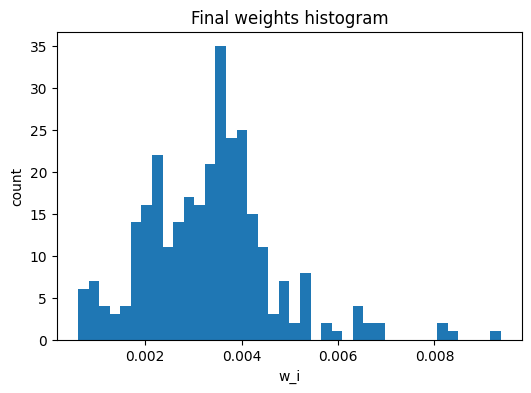

In [13]:
# === Cell 10: quick summary + histogram ===
stats = weight_stats(phi, X, lambda_w)
print("Final weights → H={H:.3f}, ESS={ESS:.1f}, min={wmin:.3e}, max={wmax:.3e}".format(**stats))

# histogram (no seaborn; GPU-safe)
w_np = compute_w(phi, X, lambda_w).cpu().numpy()
plt.figure(figsize=(6,4))
plt.hist(w_np, bins=40)
plt.title("Final weights histogram")
plt.xlabel("w_i"); plt.ylabel("count")
plt.show()


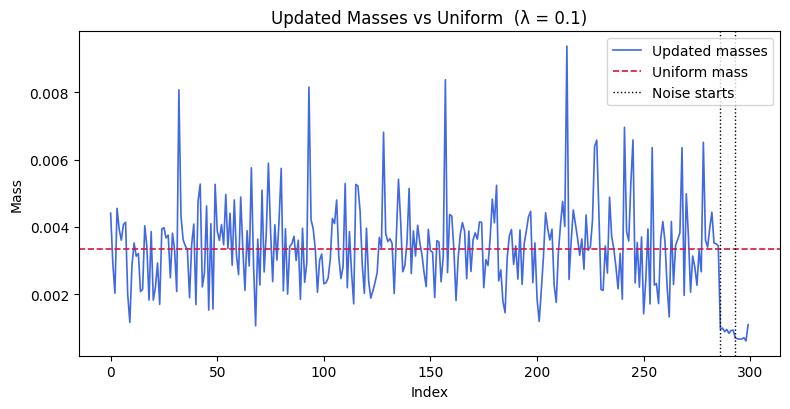

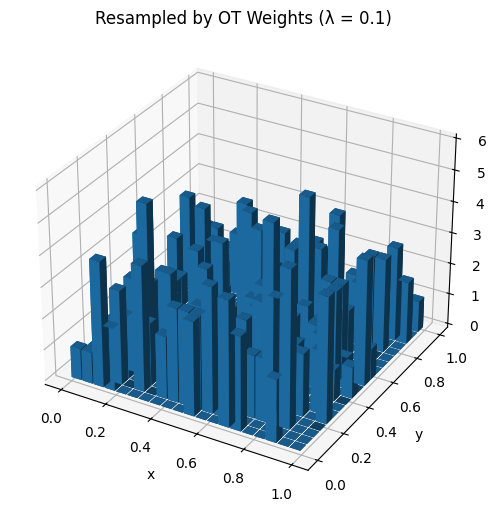

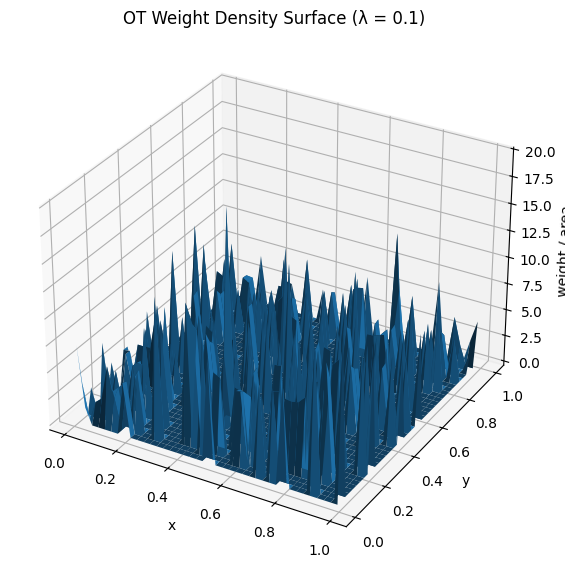

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- we already have ---
# X       : torch.Tensor (N,2)
# w_np    : numpy array of weights, shape (N,)
# lambda_w: scalar value
# noise1, noise2, signal arrays also defined

X_np = X.cpu().numpy()
N = X.shape[0]
uniform = 1.0 / N

n_noise = noise1.shape[0]
n_signal = N - 2*n_noise
i1, i2 = n_signal, n_signal + n_noise

# === 1) Line plot: updated masses vs uniform ===
plt.figure(figsize=(8,4.2))
plt.plot(np.arange(N), w_np, lw=1.2, color="royalblue", label="Updated masses")
plt.axhline(uniform, color="crimson", ls="--", lw=1.2, label="Uniform mass")
plt.axvline(i1, color="k", ls=":", lw=1.0, label="Noise starts")
plt.axvline(i2, color="k", ls=":", lw=1.0)
plt.title(rf"Updated Masses vs Uniform  (λ = {lambda_w})")
plt.xlabel("Index"); plt.ylabel("Mass")
plt.legend()
plt.tight_layout()
plt.show()

# === 2) 3D histogram of resampled data ===
idx = np.random.choice(len(X_np), size=len(X_np), p=w_np)   # resample
X_res = X_np[idx]
nbins = 20
H, xedges, yedges = np.histogram2d(X_res[:,0], X_res[:,1],
                                   bins=nbins, range=((0,1),(0,1)))
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
xpos = xpos.ravel(); ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = (xedges[1]-xedges[0])*0.9
dy = (yedges[1]-yedges[0])*0.9
dz = H.ravel()

fig = plt.figure(figsize=(7.5,5.2))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
ax.set_title(rf"Resampled by OT Weights (λ = {lambda_w})")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("count")
plt.tight_layout()
plt.show()

# === 3) Surface plot of OT weight density ===
bins = 40
Wsum, xedges, yedges = np.histogram2d(X_np[:,0], X_np[:,1],
                                      bins=bins, range=((0,1),(0,1)),
                                      weights=w_np)
cell_area = (xedges[1]-xedges[0])*(yedges[1]-yedges[0])
Z = Wsum / cell_area
xc = 0.5*(xedges[:-1] + xedges[1:])
yc = 0.5*(yedges[:-1] + yedges[1:])
Xg, Yg = np.meshgrid(xc, yc, indexing='ij')

fig = plt.figure(figsize=(7.5,5.8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Z, linewidth=0, antialiased=True, rstride=1, cstride=1)
ax.set_title(rf"OT Weight Density Surface (λ = {lambda_w})")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("weight / area")
plt.tight_layout()
plt.show()


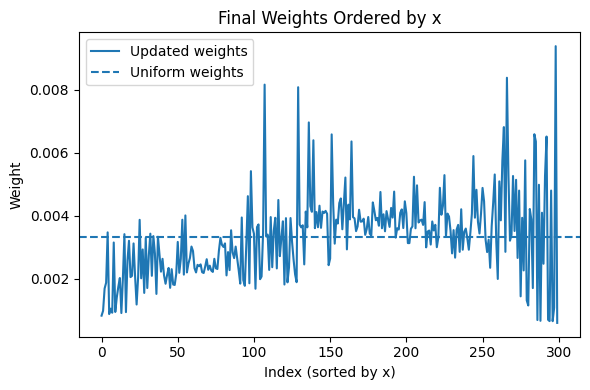

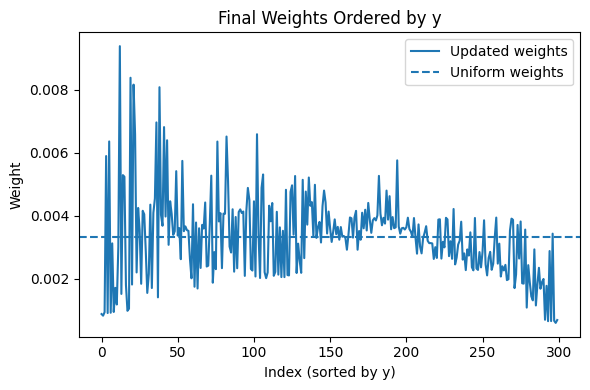

In [15]:
# --- 1) Compute final weights and pull data to numpy ---
with torch.no_grad():
    w = compute_w(phi, X, lambda_w).detach().cpu().numpy()  # shape (n,)
X_np = X.detach().cpu().numpy()                              # shape (n,2)
n = len(w)
uniform_w = 1.0 / n

# --- 2) Plot weights ordered by x ---
idx_by_x = np.argsort(X_np[:, 0])

plt.figure(figsize=(6,4))
plt.plot(np.arange(n), w[idx_by_x], label="Updated weights")
plt.axhline(uniform_w, linestyle="--", label="Uniform weights")
plt.title("Final Weights Ordered by x")
plt.xlabel("Index (sorted by x)")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3) Plot weights ordered by y ---
idx_by_y = np.argsort(X_np[:, 1])

plt.figure(figsize=(6,4))
plt.plot(np.arange(n), w[idx_by_y], label="Updated weights")
plt.axhline(uniform_w, linestyle="--", label="Uniform weights")
plt.title("Final Weights Ordered by y")
plt.xlabel("Index (sorted by y)")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()
